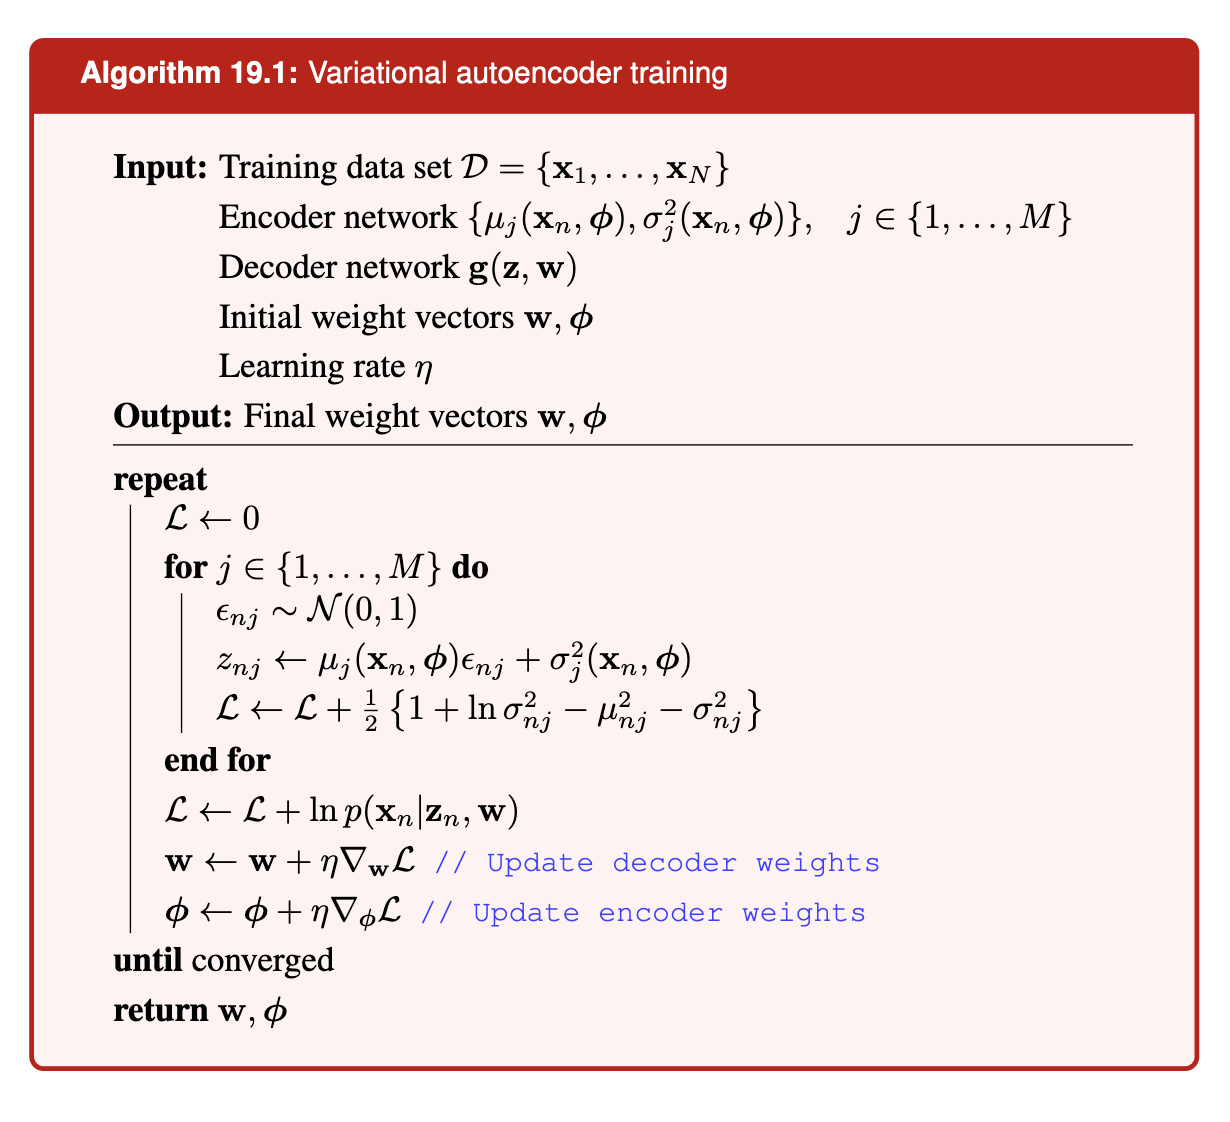

M = size of mini-batch

VAE från Google [https://arxiv.org/pdf/2208.11970.pdf](https://arxiv.org/pdf/2208.11970.pdf)

VAE is a likelihood-based model consisting of a Encoder and a Decoder.


# Overview

Three key ideas in VAE:

- (i) use of ELBO to approximate the likehood function
- (ii) amortized inference for the encoder network
- (iii) training of encoder tractable due to _reparameterization trick_

# Encoder

Formalized as $q_\phi(z|x)$. Encoder network usually either CNN or MLP:

- CNN good for images
- MLP good for everything

# Decoder

Formalized as $p_\theta(x|z)$. Converts a latent vector into an observation.

# Loss Function

Split the loss function into two parts:

- (i) reconstruction term -- $E_{q_\phi(z|x)}[\log p_\theta(x|z)]$
- (ii) KL divergence (or _prior matching term_) -- $D_{KL}(q_\phi(z|x) || p (z))$ -- can be integrated analytically when latent variables are modelled with known distributions. Interpreted as regularizing $\phi$ and pushing it close to the prior $p_\theta(z)$

The aim is to **maximize** the reconstruction term, and **minimize** the KL divergence term, pushing the encoder to be close to the unknown prior $p(x)$. The loss term is called the _evidence lower bound_ (ELBO):

$$
\mathcal{L}(\theta, \phi; x) = E_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p (z))
$$

The objective is to maximize the negative ELBO.

# Optimizizer

- SGD
- AdaGrad
- ADAM
